In [1]:
import numpy as np
import tensorflow as tf
import cv2
import os
from tqdm import tqdm
import keras

import re
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.preprocessing.image import img_to_array
from keras.layers import MaxPool2D, Conv2D, UpSampling2D, Input, Dropout
from keras import backend as K


# to get the files in proper order
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(data, key=alphanum_key)




NumPy (np):                 Library for numerical operations in Python.
TensorFlow (tf):            Open-source machine learning library.
OpenCV (cv2):               Library for computer vision tasks.
OS (os):                    Provides a way of interacting with the operating system.
TQDM (tqdm):                Library for creating progress bars during loops.
Keras:                      High-level neural networks API running on top of TensorFlow.
Re (re):                    Regular expression operations for string manipulation.
Matplotlib (plt):           Plotting library for creating visualizations.

In [2]:
# defining the size of the image
SIZE = 160
color_img = []
path = 'landscape Images/color'
files = os.listdir(path)
files = sorted_alphanumeric(files)

for i in tqdm(files):
    if i == '1000.jpg':
        break
    else:
        img = cv2.imread(path + '/' + i, 1)
        # open cv reads images in BGR format so we have to convert it to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        color_img.append(img_to_array(img))




 14%|█▍        | 1000/7129 [00:49<05:01, 20.31it/s]


The tqdm function provides a progress bar for the loop, making it visually informative.

cv2.imread(path + '/' + i, 1): Reads the image using OpenCV. The second argument (1) specifies to read the image in color (BGR format).

cv2.cvtColor(img, cv2.COLOR_BGR2RGB): Converts the image from BGR to RGB format.

The line cv2.cvtColor(img, cv2.COLOR_BGR2RGB) is needed because OpenCV reads images in the BGR (Blue-Green-Red) color format by default. However, many other image processing libraries and applications, including Matplotlib, expect images to be in RGB (Red-Green-Blue) format.

cv2.resize(img, (SIZE, SIZE)): Resizes the image to the specified size.

img.astype('float32') / 255.0: Normalizes pixel values to the range [0, 1] by converting to float32 and dividing by 255.0

Neural networks, especially deep convolutional networks, can converge faster and have more stable training when input values are within a small and well-behaved range.
Gradient Descent:smoother , prevent issues like exploding or vanishing gradients,unnormalized or poorly scaled data.

color_img.append(img_to_array(img)): Converts the image to a NumPy array and appends it to the color_img list.

In [15]:
import os
import cv2
from tqdm import tqdm

# Function to convert color image to grayscale and save
def convert_and_save_grayscale(input_path, output_path, size=160):
    files = os.listdir(input_path)
    files = sorted(files)  # Assuming sorted by filename
    for i in tqdm(files):
        if i == '1000.jpg':
            break
        else:
            img = cv2.imread(os.path.join(input_path, i), 1)
            # Convert to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # Resize image
            img = cv2.resize(img, (size, size))
            img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

            # Save grayscale image
            output_file_path = os.path.join(output_path, f"{os.path.splitext(i)[0]}_gray.jpg")
            cv2.imwrite(output_file_path, img_gray)

# Define the size of the image
SIZE = 160

# Define paths
color_image_path = 'landscape Images/color'
output_folder_path = 'landscape Images/greyscale'

# Create the output folder if it doesn't exist
os.makedirs(output_folder_path, exist_ok=True)

# Call the function to convert and save grayscale images
convert_and_save_grayscale(color_image_path, output_folder_path, SIZE)


  0%|          | 4/7129 [00:00<00:17, 411.91it/s]


In [3]:
gray_img = []
path = 'landscape Images/gray'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
    if i == '1000.jpg':
        break
    else:
        img = cv2.imread(path + '/' + i, 1)

        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        gray_img.append(img_to_array(img))




 14%|█▍        | 1000/7129 [00:23<02:26, 41.89it/s]


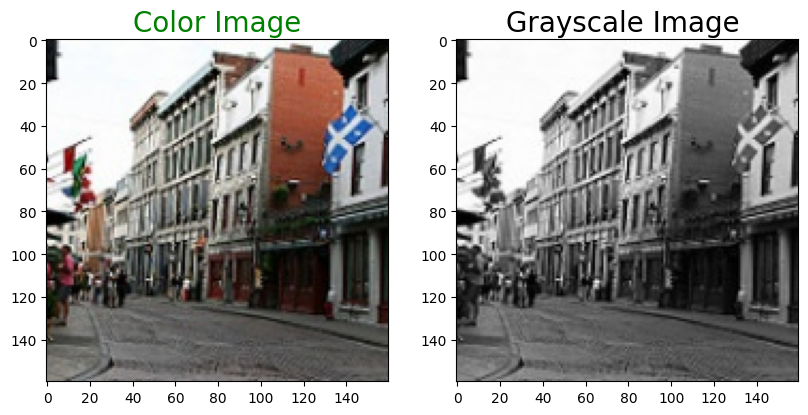

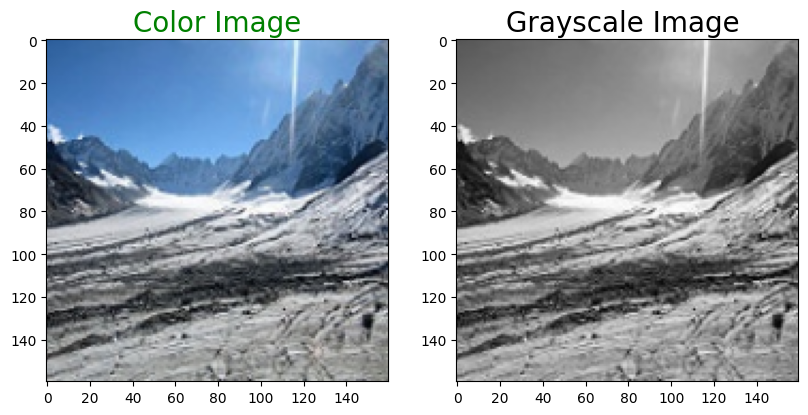

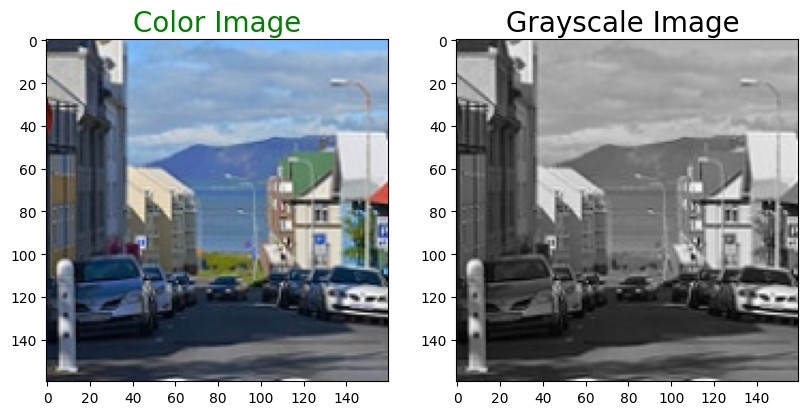

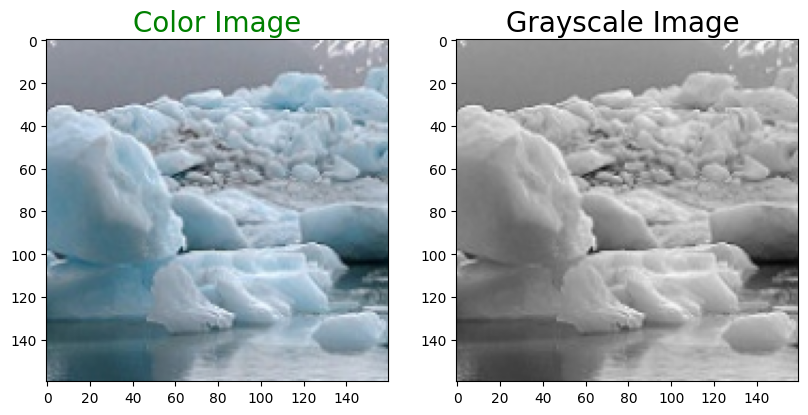

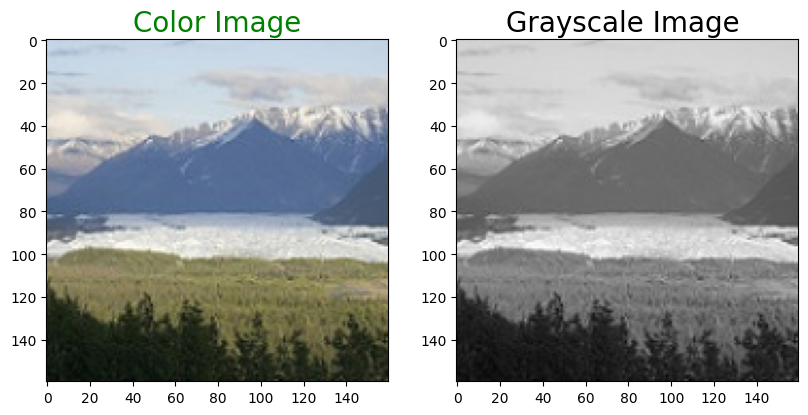

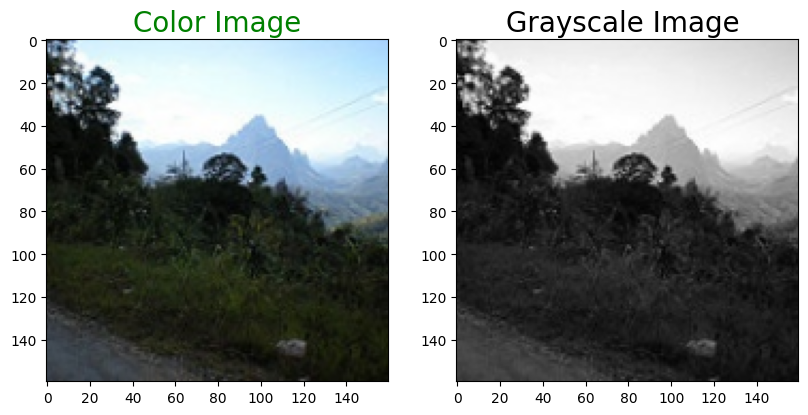

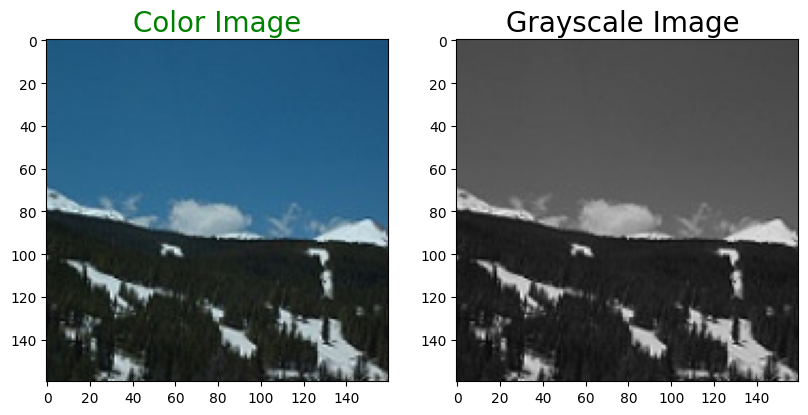

In [4]:
# defining function to plot images pair
def plot_images(color, grayscale):
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    plt.title('Color Image', color='green', fontsize=20)
    plt.imshow(color)
    plt.subplot(1, 3, 2)
    plt.title('Grayscale Image ', color='black', fontsize=20)
    plt.imshow(grayscale)

    plt.show()


for i in range(6, 12):
    plot_images(color_img[i], gray_img[i])




In [5]:
# Assuming you have loaded and preprocessed gray_img and color_img

# Define the size of the image
SIZE = 160

# Assuming your dataset has 1000 images
total_images = 1000

# Split the dataset into training and testing sets
train_gray_image = gray_img[:int(0.8 * total_images)]
train_color_image = color_img[:int(0.8 * total_images)]

test_gray_image = gray_img[int(0.8 * total_images):]
test_color_image = color_img[int(0.8 * total_images):]

# Reshaping for the CNN
train_g = np.reshape(train_gray_image, (len(train_gray_image), SIZE, SIZE, 3))
train_c = np.reshape(train_color_image, (len(train_color_image), SIZE, SIZE, 3))
print('Train color image shape:', train_c.shape)

test_g = np.reshape(test_gray_image, (len(test_gray_image), SIZE, SIZE, 3))
test_c = np.reshape(test_color_image, (len(test_color_image), SIZE, SIZE, 3))
print('Test color image shape:', test_c.shape)


Train color image shape: (800, 160, 160, 3)
Test color image shape: (200, 160, 160, 3)


In [6]:
from keras import layers


def down(filters, kernel_size, apply_batch_normalization=True):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters, kernel_size, padding='same', strides=2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample


def up(filters, kernel_size, dropout=False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size, padding='same', strides=2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(keras.layers.LeakyReLU())
    return upsample


def model():
    inputs = layers.Input(shape=[160, 160, 3])
    d1 = down(128, (3, 3), False)(inputs)
    d2 = down(128, (3, 3), False)(d1)
    d3 = down(256, (3, 3), True)(d2)
    d4 = down(512, (3, 3), True)(d3)

    d5 = down(512, (3, 3), True)(d4)
    #upsampling
    u1 = up(512, (3, 3), False)(d5)
    u1 = layers.concatenate([u1, d4])
    u2 = up(256, (3, 3), False)(u1)
    u2 = layers.concatenate([u2, d3])
    u3 = up(128, (3, 3), False)(u2)
    u3 = layers.concatenate([u3, d2])
    u4 = up(128, (3, 3), False)(u3)
    u4 = layers.concatenate([u4, d1])
    u5 = up(3, (3, 3), False)(u4)
    u5 = layers.concatenate([u5, inputs])
    output = layers.Conv2D(3, (2, 2), strides=1, padding='same')(u5)
    return tf.keras.Model(inputs=inputs, outputs=output)




In [7]:
model = model()
model.summary()





Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 80, 80, 128)          3584      ['input_1[0][0]']             
                                                                                                  
 sequential_1 (Sequential)   (None, 40, 40, 128)          147584    ['sequential[0][0]']          
                                                                                                  
 sequential_2 (Sequential)   (None, 20, 20, 256)          296192    ['sequential_1[0][0]']        
                                                                                            

In [8]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_absolute_error',
              metrics=['acc'])

model.fit(train_g, train_c, epochs=2, batch_size=10, verbose=0)

1/1 [==============================] - 1s 1s/step


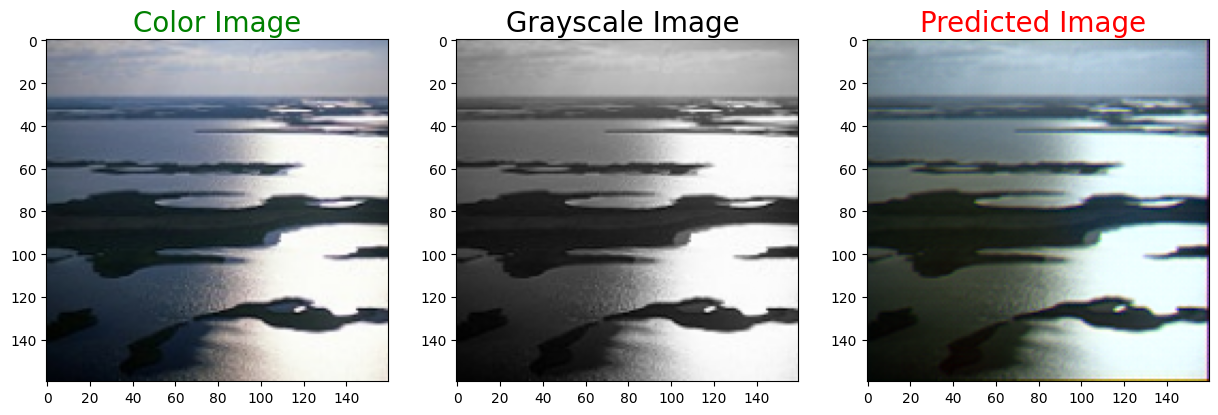

1/1 [==============================] - 0s 93ms/step


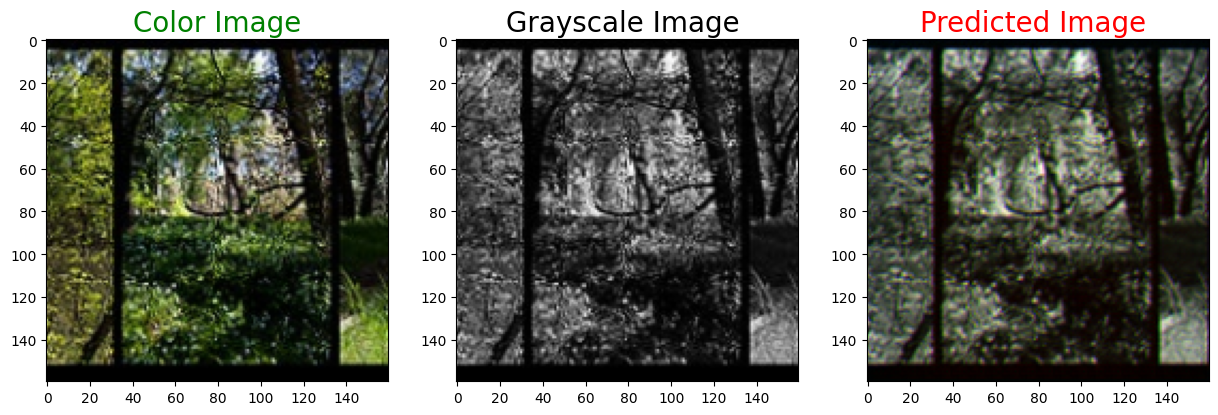

1/1 [==============================] - 0s 93ms/step


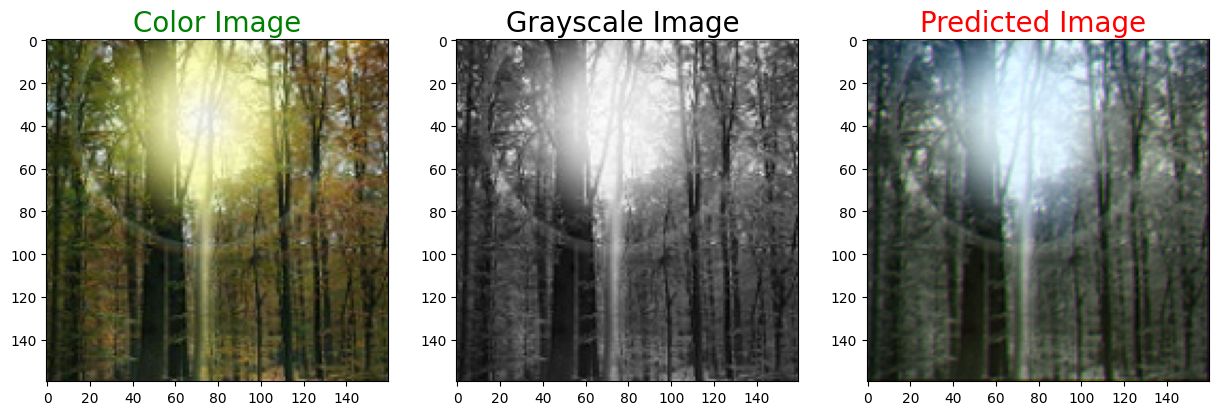

1/1 [==============================] - 0s 84ms/step


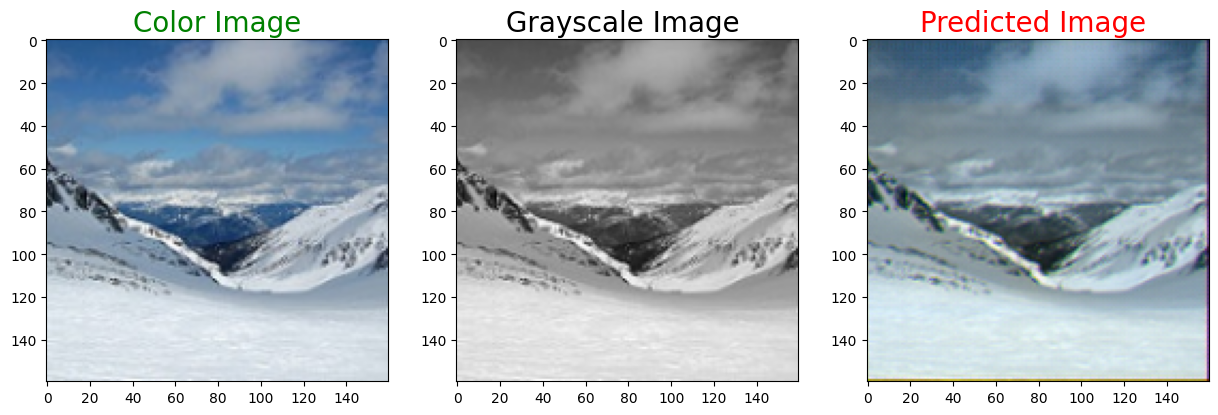

1/1 [==============================] - 0s 86ms/step


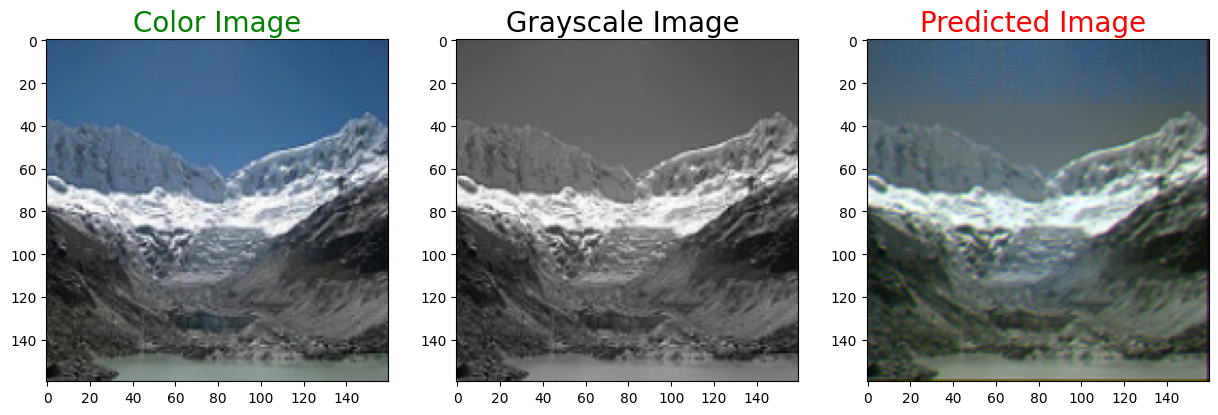

1/1 [==============================] - 0s 66ms/step


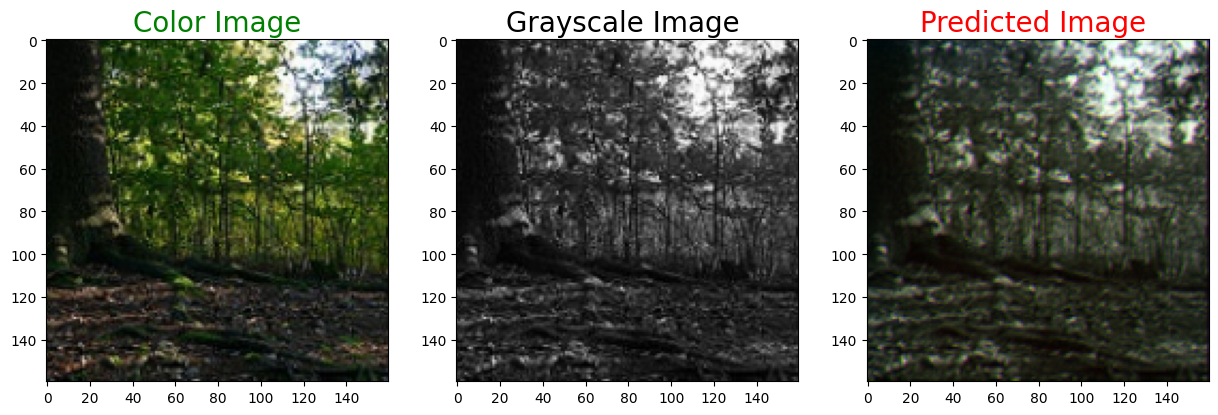

1/1 [==============================] - 0s 68ms/step


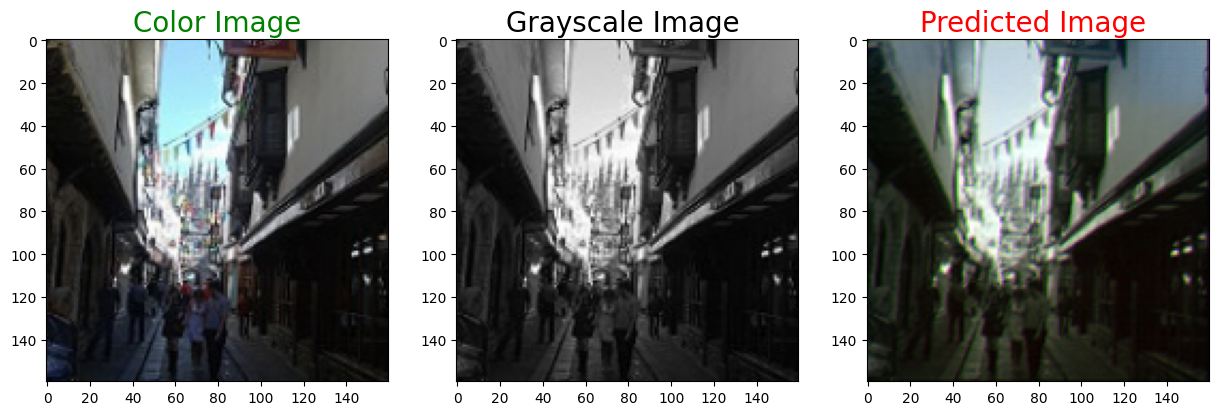

1/1 [==============================] - 0s 87ms/step


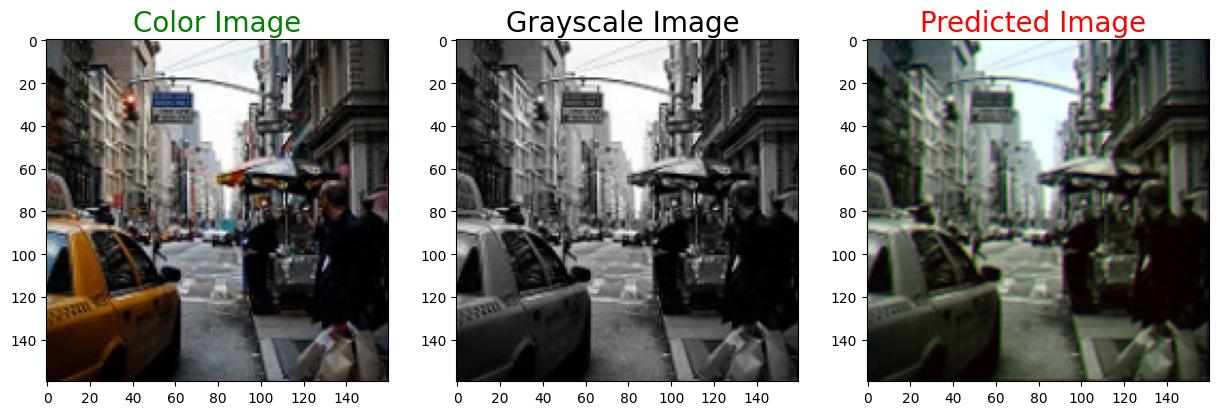

In [9]:
# defining function to plot images pair
def plot_images(color, grayscale, predicted):
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    plt.title('Color Image', color='green', fontsize=20)
    plt.imshow(color)
    plt.subplot(1, 3, 2)
    plt.title('Grayscale Image ', color='black', fontsize=20)
    plt.imshow(grayscale)
    plt.subplot(1, 3, 3)
    plt.title('Predicted Image ', color='Red', fontsize=20)
    plt.imshow(predicted)

    plt.show()


for i in range(50, 58):
    predicted = np.clip(model.predict(test_gray_image[i].reshape(1, SIZE, SIZE, 3)), 0.0, 1.0).reshape(SIZE, SIZE, 3)
    plot_images(test_color_image[i], test_gray_image[i], predicted)




In [10]:
history = model.fit(train_g, train_c, epochs=2, batch_size=10, verbose=1)

# Print the history
print(history.history)


Epoch 1/2
80/80 [==============================] - 139s 2s/step - loss: 0.0640 - acc: 0.4452
Epoch 2/2
80/80 [==============================] - 134s 2s/step - loss: 0.0599 - acc: 0.4502
{'loss': [0.06402388960123062, 0.05986807867884636], 'acc': [0.4452047348022461, 0.4501881003379822]}


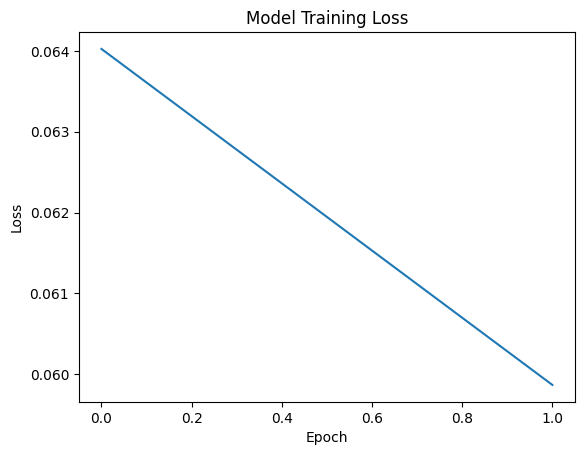

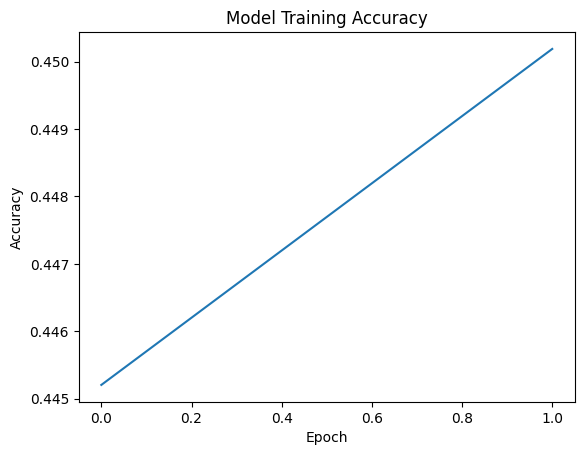

In [11]:
import matplotlib.pyplot as plt

# Plot training loss
plt.plot(history.history['loss'])
plt.title('Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Plot training accuracy (if applicable)
if 'acc' in history.history:
    plt.plot(history.history['acc'])
    plt.title('Model Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()


In [12]:
# Evaluate the model on the test set
evaluation = model.evaluate(test_g, test_c)
print("Test Loss:", evaluation[0])
print("Test Accuracy:", evaluation[1])

# Train the model with validation data
history = model.fit(
    train_g, train_c, epochs=2, batch_size=10,
    validation_data=(test_g, test_c), verbose=1

)



7/7 [==============================] - 8s 935ms/step - loss: 0.0651 - acc: 0.2863
Test Loss: 0.06512925028800964
Test Accuracy: 0.286297082901001
Epoch 1/2
80/80 [==============================] - 142s 2s/step - loss: 0.0573 - acc: 0.4489 - val_loss: 0.0534 - val_acc: 0.4463
Epoch 2/2
80/80 [==============================] - 143s 2s/step - loss: 0.0547 - acc: 0.4601 - val_loss: 0.0549 - val_acc: 0.4166
